In [1]:
#import and set data
import pandas as pd
import numpy as np
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

# DATA_PATH = "../../data/"
# data = pd.read_pickle(f"{DATA_PATH}df_filter_dummy_{TARGET_CITY}.pkl")

#==========get data=========================================
print("DATA LOADING........")
cat_arti_mat = np.loadtxt("../../result/topic_idx.csv", delimiter=",", dtype = np.int8)
data_all = pd.read_csv("../../data/topic_data.csv")
print("DONE")

#TARGET_CITY = str(input("Which City You want to draw network?  ex)포항시   :  "))
TARGET_CITY = '포항시'



print("If you don't have NanumGothic in your computer, It will rasie error here")
import matplotlib.font_manager as fm
import matplotlib

font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
fontprop = fm.FontProperties(fname=font_path, size=18)
font_name = fm.FontProperties(fname="/usr/share/fonts/truetype/nanum/NanumGothic.ttf").get_name()

matplotlib.rcParams['font.family'] ='NanumGothic'
matplotlib.rcParams['axes.unicode_minus'] = False


DATA LOADING........


Duplicate key in file PosixPath('/home/mglee/anaconda3/envs/svmglee/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  NanumGothic')


DONE
If you don't have NanumGothic in your computer, It will rasie error here


In [2]:
for topic in range(1):
    print(f"Topic {topic +1} START")
    data_topic = data_all.iloc[cat_arti_mat[topic] == 1, :]

#========filter by city and separate into three data set======================
    data = data_topic[data_topic['city'] == TARGET_CITY]
    data.reset_index(inplace=True, drop = True)
    print(f"{TARGET_CITY} START")

    data1 = data[data['일자'] < 20000000]
    data1.reset_index(inplace=True, drop = True)
    data2 = data[data['일자'] < 20100000]
    data2 = data2[data2['일자'] > 20000000]
    data2.reset_index(inplace=True, drop = True)
    data3 = data[data['일자'] > 20100000]
    data3.reset_index(inplace=True, drop = True)

    print(f"{topic+1} / total : {data.shape}, ")
    print(f"{topic+1} / period1 : {data1.shape}, ")
    print(f"{topic+1} / period2 : {data2.shape}, ")
    print(f"{topic+1} / period3 : {data3.shape}, ")

    data_lst = [data, data1, data2, data3]


Topic 1 START
포항시 START
1 / total : (4240, 23), 
1 / period1 : (197, 23), 
1 / period2 : (459, 23), 
1 / period3 : (3584, 23), 


In [20]:


#========for loop for three period===============
for period, dataset in enumerate(data_lst):
    print(f"====================C{TARGET_CITY}_T{topic + 1}_P{period} START======================")
    keyword_set = dataset['특성추출(가중치순 상위 50개)']
    key_set = []
    for item in keyword_set:
        item = str(item)
        splited = item.split(",")
        temp = []
        for tok in splited:                         
            temp.append(tok.replace(" ", ""))
        key_set.append(temp)
    print("Keyword_set_prepared")
    #==================apriori=====================================
    #apriori
    from mlxtend.preprocessing import TransactionEncoder
    from mlxtend.frequent_patterns import apriori

    te = TransactionEncoder()
    te_result = te.fit(key_set).transform(key_set)
    key_df = pd.DataFrame(te_result, columns=te.columns_)

    itemset = apriori(key_df, min_support=0.1, use_colnames=True)
    print('itemset_built')
    from mlxtend.frequent_patterns import association_rules
    apriori_result = association_rules(itemset, metric="confidence", min_threshold=0.7)

    idx_lst = []
    i = 0
    for a, b in zip(apriori_result['antecedents'], apriori_result['consequents']):
        if len(a) == 1:
            if len(b) == 1:
                idx_lst.append(i)
        i += 1  
    
    apriori_single = apriori_result.iloc[idx_lst,:]

    #===============Draw Network=======================================
    network_data = apriori_single[['antecedents', 'consequents', 'lift']]
    print(f"netword_data : {network_data.shape}")

    import matplotlib.pyplot as plt
    import networkx as nx

    node_lst = []
    for node in network_data['antecedents']:
        node_lst.append(', '.join(list(node)))

    thold = 1.5
    qtl = pd.DataFrame(network_data['lift']).quantile([0.5, 0.7, 0.9, 0.99])
    print(qtl)

    #===============Build graph===================================
    graph = nx.DiGraph()
    child_node = []
    print("H = 0")

    # for i in tqdm(range(len(network_data))):
    #     a, b, c = network_data.iloc[i, :]
    #     a = ', '.join(list(a))
    #     b = ', '.join(list(b))
    #     if c > thold:
    #         graph.add_edge(a, b, weight = round(c,3))
    #         child_node.append(b)
    #     else:
    #        pass

    network_data = network_data[network_data['lift'] > thold]
    for i in tqdm(range(len(network_data))):
        a, b, c = network_data.iloc[i, :]
        a = ', '.join(list(a))
        b = ', '.join(list(b))
        graph.add_edge(a, b, weight = round(c,3))


====================C포항시_T1_P0 START======================
Keyword_set_prepared
itemset_built
netword_data : (69, 3)
          lift
0.50  1.104926
0.70  1.265204
0.90  2.413631
0.99  3.439957
H = 0


100%|██████████| 12/12 [00:00<00:00, 9453.73it/s]


====================C포항시_T1_P1 START======================
Keyword_set_prepared
itemset_built
netword_data : (24, 3)
          lift
0.50  1.000000
0.70  1.144251
0.90  1.695650
0.99  5.244213
H = 0


100%|██████████| 3/3 [00:00<00:00, 7117.03it/s]


====================C포항시_T1_P2 START======================
Keyword_set_prepared
itemset_built
netword_data : (38, 3)
          lift
0.50  1.024554
0.70  1.085742
0.90  1.110863
0.99  1.160599
H = 0


0it [00:00, ?it/s]

====================C포항시_T1_P3 START======================
Keyword_set_prepared


itemset_built
netword_data : (83, 3)
          lift
0.50  1.076650
0.70  1.287146
0.90  2.393410
0.99  3.158069
H = 0


100%|██████████| 15/15 [00:00<00:00, 9751.17it/s]


In [25]:
keyword_list = pd.read_excel("../../data/Text_keyword_0620.xlsx")

In [56]:
key_set = set(keyword_list['Target 키워드'].apply(lambda x : x.strip()))

In [52]:
key_match_lst = []
for node in graph.nodes:
    if node in key_set:
        key_match_lst.append(node)

In [55]:
for i in graph.nodes:
    print(i)

기상청
규모
동경
북쪽
여진
지진
북구
지역


In [53]:
key_match_lst

['지역']

Draw Net


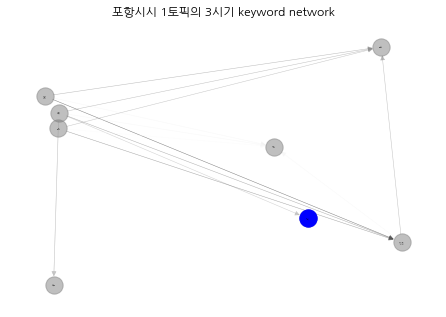

In [47]:
print("Draw Net")
#===========Check edges and weights=====================
try:
    edges,weights = zip(*nx.get_edge_attributes(graph,'weight').items())
except:
    print(f"It it empty graph")
else:
    n_size = dict(graph.degree)
    pos = nx.kamada_kawai_layout(graph)
    nx.draw(graph, nodelist=n_size.keys(), 
            with_labels = True, font_family = font_name, font_size = 2,
            pos = pos,
            alpha = 0.5,
            node_color = 'grey',
            edgelist=edges, edge_color=weights, width=0.5, edge_cmap=plt.cm.binary)
    nx.draw_networkx_nodes(
        graph.subgraph(key_match_lst),
        pos = pos,
        node_color = 'blue'
    )

    plt.title(f"{TARGET_CITY}시 {topic+1}토픽의 {period}시기 keyword network")
    #plt.show(block=False)
    plt.show()
